In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [36]:
data = pd.read_excel('/content/vrp_instance_n32_k5(1).xlsx')

In [37]:
data.head()

,xcodinate,ycordinate,demand
0,82,76,0
1,96,44,19
2,50,5,21
3,49,8,6
4,13,7,19


In [23]:
def plot(data):
  plt.plot(data['xcodinate'][0],data['ycordinate'][0],marker = "^", color = 'r',label = 'depot')
  plt.scatter(data['xcodinate'][1:], data['ycordinate'][1:], marker = "o", color = 'b', label = 'city')
  plt.legend()
  plt.show()


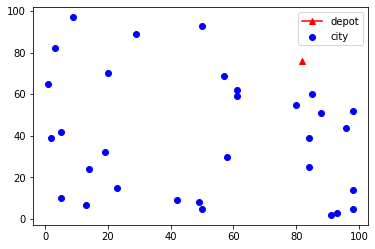

In [24]:
plot(data)

In [25]:
k = 5 #no. of clusters or no. of vehicles
n = 31 #no. of cities excluding depot
capacity = 100 #capacity of each cluster

In [41]:
#initial k centroids from first k largest(based on demand) cities
sorted_data = data.sort_values(by='demand', ascending=False)
s_data = sorted_data[0:int(k)]
s_data.reset_index(drop=True, inplace=True)
centroids = []
for i in range(k):
  centroids.append(list((s_data['xcodinate'][i],s_data['ycordinate'][i])))
centroids_index = list(sorted_data[0:5].index)

In [40]:
s_data

,xcodinate,ycordinate,demand
0,61,62,24
1,9,97,24
2,93,3,24
3,1,65,22
4,50,5,21


In [42]:
centroids

[[61, 62], [9, 97], [93, 3], [1, 65], [50, 5]]

In [48]:
def distance_calculator(data,centroids,centroids_index):
  new_data = data.drop(index = centroids_index)
  new_data = new_data.drop(index = [0]) #dropping the depot
  saved_index = [x for x in range(1,len(data)) if x not in centroids_index]
  new_data.reset_index(drop = True, inplace = True)
  distance_matrix = np.zeros(shape = (len(new_data),len(centroids_index)))

  for i in range(len(new_data)):
    for j in range(len(centroids_index)):
      distance_matrix[i,j] = np.round(np.sqrt((new_data['xcodinate'][i]-centroids[j][0])**2 + (new_data['ycordinate'][i]-centroids[j][1])**2 ),1)
  return distance_matrix, saved_index, new_data

In [46]:
#calculating new centroids
def calculate_centroid_coordinates(data,centroids_index):
  return list((np.average(data['xcodinate'][centroids_index]),np.average(data['ycordinate'][centroids_index])))

In [49]:
def cluster(data,n,k,capacity,centroids,centroids_index):
  #give k clusters. A city will always be in a cluster

  ##initial k centroids from first k largest(based on demand) cities
  #sorted_data = data.sort_values(by='demand', ascending=False)
  #s_data = sorted_data[0:int(k)]
  #s_data.reset_index(drop=True, inplace=True)
  #centroids = []
  #for i in range(k):
    #centroids.append(list((s_data['xcodinate'],s_data['ycordinate'])))
  #centroids_index = list(sorted_data[0:5].index)
  
  dist_matx, saved_index, new_data = distance_calculator(data,centroids,centroids_index)
  df = pd.DataFrame(dist_matx, index = saved_index, columns = centroids_index)

  #now we fave a df with k columns and n-k rows and each value in ith row and jth column is distance between ith city and jth centriod
  priority_df = df.copy()
  for i in saved_index:
    for j in centroids_index:
      priority_df[j][i] = np.round(priority_df[j][i]/data['demand'][i],1)

  lol = []  #list of list contains k list each list contain index for cities in one cluster
  df2 = priority_df.copy()
  for i in centroids_index:
    df2 = df2.sort_values(by = i, ascending=False)
    sum = data['demand'][i]
    l = []
    for j in list(df2.index) :
        sum += data['demand'][j]
        if sum > capacity :
          break
        l.append(j) 
    lol.append(l)
    df2.drop(index = l, inplace=True)
  
  for l in lol :
    if len(l)==0:
      k = lol.index(l)
      if k == 0:
        return lol
  lol = lol[:k]
             
  return lol

In [50]:
lol = cluster(data,n,k,capacity,centroids,centroids_index)

In [51]:
for l in lol :
  print(calculate_centroid_coordinates(data,l))

[32.25, 36.75]
[79.5, 31.666666666666668]
[30.5, 52.0]
[91.5, 46.5]


In [52]:
centroid_coordinate = []
for l in lol :
  centroid_coordinate.append(calculate_centroid_coordinates(data,l))

In [53]:
centroid_coordinate

[[32.25, 36.75], [79.5, 31.666666666666668], [30.5, 52.0], [91.5, 46.5]]

In [54]:
def new_distance_calculator(data,lol):
  new_data = data
  new_data = new_data.drop(index = [0]) #dropping the depot
  #new_data.reset_index(drop = True, inplace = True)
  saved_index = list(new_data.index)
  centroid_coordinate = []
  for l in lol :
    centroid_coordinate.append(calculate_centroid_coordinates(data,l))
  
  distance_matrix = np.zeros(shape = (len(new_data),len(centroid_coordinate)))

  for i in range(1,len(new_data)):
    for j in range(len(centroid_coordinate)):
      distance_matrix[i,j] = np.round(np.sqrt((new_data['xcodinate'][i]-centroid_coordinate[j][0])**2 + (new_data['ycordinate'][i]-centroid_coordinate[j][1])**2 ),1)
  return distance_matrix, saved_index

In [55]:
dmatrix, saved_index = new_distance_calculator(data,lol)

In [56]:
def cluster_again(data,lol,dmatrix,saved_index):

  df = pd.DataFrame(dmatrix, index = saved_index,columns=range(len(centroid_coordinate)))
  #data = data.drop(index = [0])
  priority_df = df.copy()
  for i in saved_index:
    for j in range(len(centroid_coordinate)):
      priority_df[j][i] = np.round(priority_df[j][i]/data['demand'][i],1)

  
  lol = []  #list of list contains k list each list contain index for cities in one cluster
  df2 = priority_df.copy()
  new_data = data
  new_data = new_data.drop(index = [0])
  for i in range(len(centroid_coordinate)):
    df2 = df2.sort_values(by = i, ascending=False)
    sum = 0
    l = []
    for j in list(df2.index) :
        sum += new_data['demand'][j]
        if sum > capacity :
          break
        l.append(j) 
    lol.append(l)
    df2.drop(index = l, inplace=True)
  
  for l in lol :
    if len(l)==0:
      k = lol.index(l)
      print(k)
  #lol = lol[:k]
             
  return lol

In [77]:
def new_plot(data,lol, centroid_coordinate):
  color_list = ['g','b','y','r']
  #m_list = ["x","o","v"]
  plt.figure(figsize=(20,10))
  plt.scatter(data['xcodinate'][0],data['ycordinate'][0],marker = "^",s = 500,color = 'pink' ,label = 'depot')
  for l in lol:
    k = lol.index(l)
    plt.scatter(data['xcodinate'][l], data['ycordinate'][l], marker = "o",s=100 ,color = color_list[lol.index(l)], label = 'city in cluster'+str(k))
    #plt.plot(data['xcodinate'][l], data['ycordinate'][l], marker = "o", color = color_list[lol.index(l)], label = 'city')
  for i in range(len(centroid_coordinate)):
    plt.scatter(centroid_coordinate[i][0],centroid_coordinate[i][1], marker = '^', s = 500,color = color_list[i], label ='cluster center'+str(i) )
  plt.legend()
  plt.xlabel('x axis')
  plt.ylabel('y axis')
  plt.show()

In [78]:
dmatrix, saved_index = new_distance_calculator(data,lol)
lol2 = cluster_again(data,lol,dmatrix,saved_index)
centroid_coordinate = []
for l in lol2 :
  centroid_coordinate.append(calculate_centroid_coordinates(data,l))
print('FIRST ITERATION------')
print('cluster centriods are')
print(centroid_coordinate)
print('clustors are')
print(lol2)

FIRST ITERATION------
cluster centriods are
[[46.06666666666667, 42.86666666666667], [53.333333333333336, 36.833333333333336], [59.0, 24.4], [41.0, 56.75]]
clustors are
[[18, 26, 14, 22, 29, 28, 20, 8, 31, 3, 5, 21, 6, 13, 10], [23, 11, 30, 16, 9, 12], [2, 17, 4, 27, 7], [19, 24, 15, 25]]


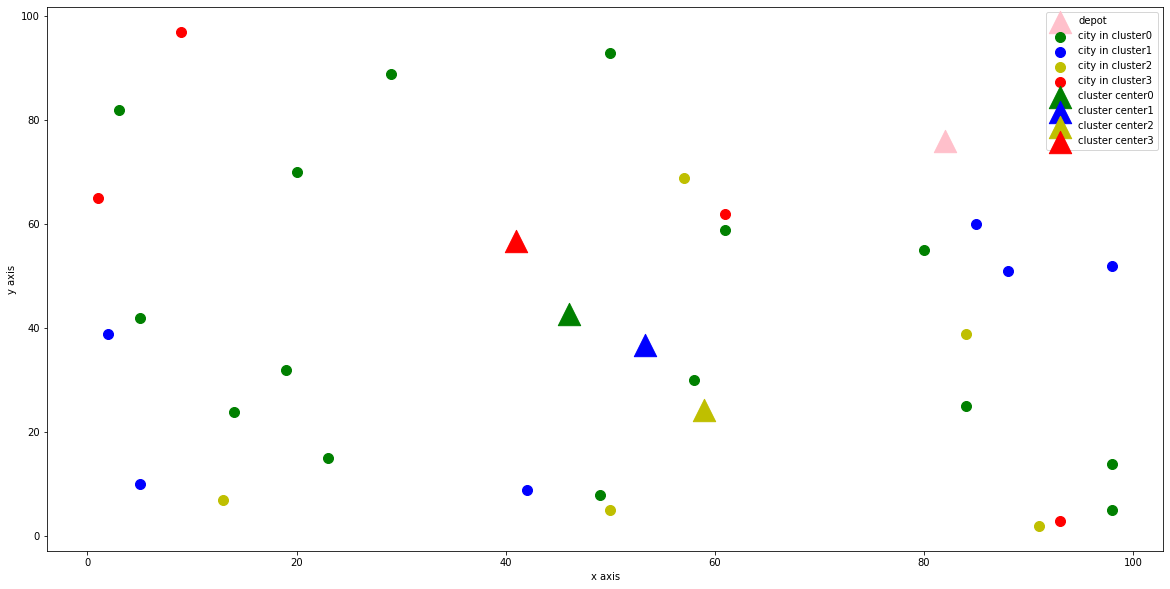

In [79]:
new_plot(data,lol2,centroid_coordinate)

In [80]:
dmatrix, saved_index = new_distance_calculator(data,lol2)
lol3 = cluster_again(data,lol,dmatrix,saved_index)
centroid_coordinate = []
for l in lol3 :
  centroid_coordinate.append(calculate_centroid_coordinates(data,l))
print('SECOND ITERATION------')
print('cluster centriods are')
print(centroid_coordinate)
print('clustors are')
print(lol3)

SECOND ITERATION------
cluster centriods are
[[39.733333333333334, 40.46666666666667], [69.16666666666667, 42.833333333333336], [72.75, 19.75], [39.75, 43.25]]
clustors are
[[18, 26, 29, 22, 14, 20, 28, 5, 8, 3, 10, 23, 31, 11, 21], [6, 30, 16, 13, 12, 9], [17, 2, 27, 19], [4, 24, 7, 15]]


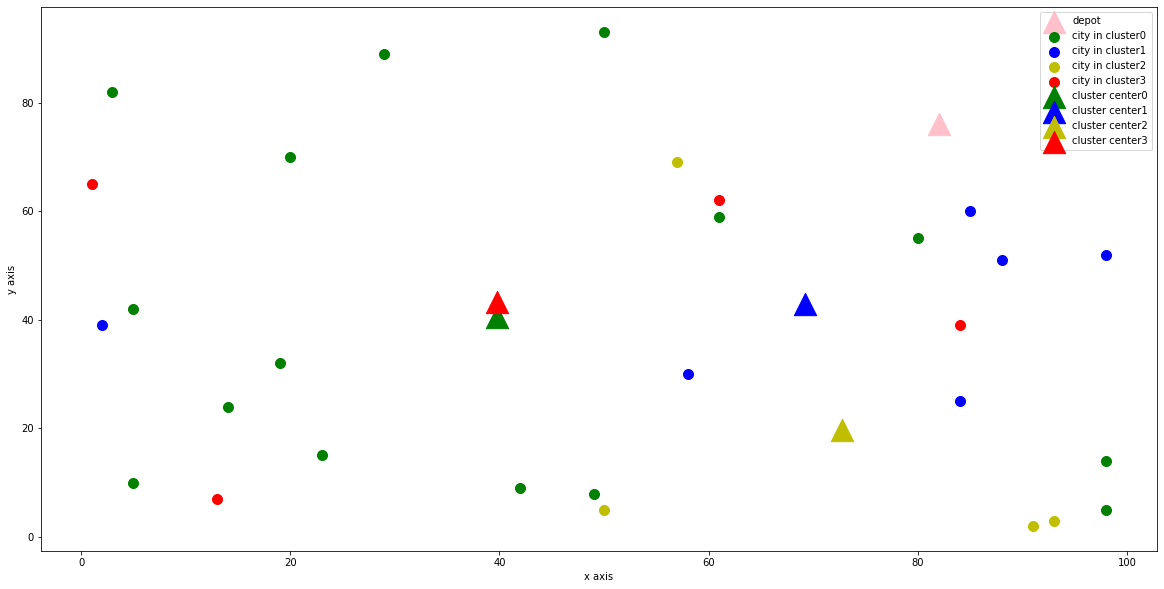

In [81]:
new_plot(data,lol3,centroid_coordinate)

In [82]:
dmatrix, saved_index = new_distance_calculator(data,lol3)
lol4 = cluster_again(data,lol,dmatrix,saved_index)
centroid_coordinate = []
for l in lol4 :
  centroid_coordinate.append(calculate_centroid_coordinates(data,l))
print('THIRD ITERATION------')
print('cluster centriods are')
print(centroid_coordinate)
print('clustors are')
print(lol4)

THIRD ITERATION------
cluster centriods are
[[43.266666666666666, 41.8], [55.6, 42.4], [67.25, 23.75], [53.0, 36.4]]
clustors are
[[18, 26, 22, 14, 29, 28, 20, 8, 3, 5, 31, 10, 21, 23, 6], [11, 30, 16, 9, 12], [13, 19, 15, 17], [2, 27, 4, 24, 7]]


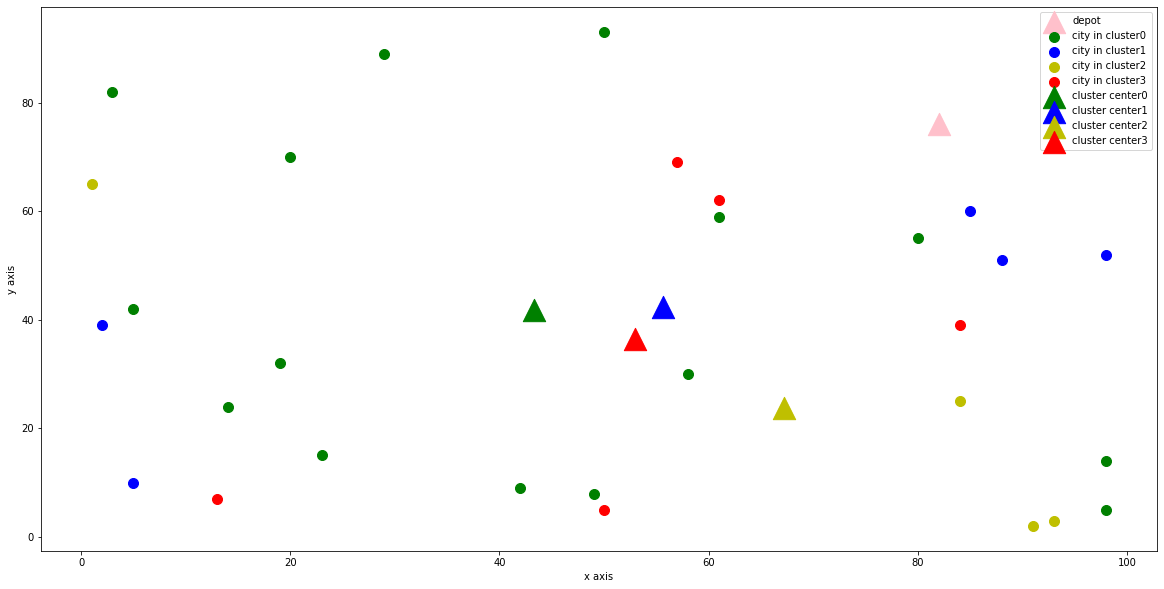

In [83]:
new_plot(data,lol4,centroid_coordinate)

In [84]:
dmatrix, saved_index = new_distance_calculator(data,lol4)
lol5 = cluster_again(data,lol,dmatrix,saved_index)
centroid_coordinate = []
for l in lol5 :
  centroid_coordinate.append(calculate_centroid_coordinates(data,l))
print('FOURTH ITERATION------')
print('cluster centriods are')
print(centroid_coordinate)
print('clustors are')
print(lol5)

FOURTH ITERATION------
cluster centriods are
[[43.266666666666666, 41.8], [60.333333333333336, 39.5], [72.75, 19.75], [21.0, 57.75]]
clustors are
[[18, 26, 29, 22, 14, 20, 28, 8, 5, 3, 10, 31, 23, 21, 6], [11, 16, 30, 12, 9, 13], [19, 17, 2, 27], [4, 24, 15, 25]]


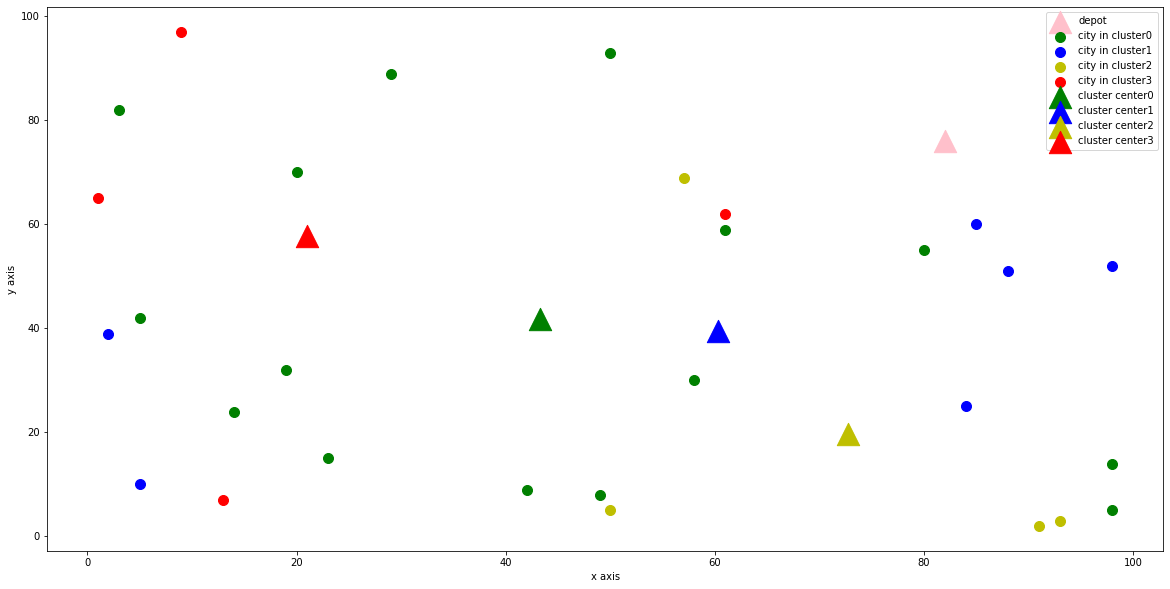

In [85]:
new_plot(data,lol5,centroid_coordinate)